### Imports

In [105]:
import pandas as pd
from pycaret.regression import *
from sklearn.model_selection import train_test_split
import h2o
from h2o.automl import H2OAutoML
import pickle
from datetime import timedelta
import talib
import numpy as np

In [106]:
# Evito que ciertas columnas se transformen a notacion cientifica en las predicciones
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

### Dataset

In [107]:
columns = [
    'Open_time',
    'Open',
    'High',
    'Low',
    'Close',
    'Number of trades',
    'Close_BTCUSDT',
    'Volume_BTCUSDT',
    'Number_of_trades_BTCUSDT',
    'Close_ETHUSDT',
    'Volume_ETHUSDT',
    'Number_of_trades_ETHUSDT',
    'Close_BNBUSDT',
    'Volume_BNBUSDT',
    'Number_of_trades_BNBUSDT',
    'SMA_20',
    'EMA_20',
    'Upper_Band',
    'Middle_Band',
    'Lower_Band',
    'RSI',
    'buy_1000x_high_coinbase',
    'sell_1000x_high_coinbase',
    'total_trades_coinbase',	
    'Tweets_Utilizados',
    'Tweets_Utilizados_coin',
    'Tweets_Utilizados_referentes',
    'Tweets_Utilizados_whale_alert',
    'Buy_1000x_high',
    'sell_1000x_high',
    'total_trades_binance'
]

columns_to_model = [
    'Open',
    'High',
    'Low',
    'Close',
    'Number of trades',
    'Buy_1000x_high',
    'sell_1000x_high',
]


# VOLVER A AGRAGAR LAS COLUMNAS DE ACA ABAJO PARA LA PRIMER VERSION PERFORMANTE DE H2O
# Number_of_trades_BTCUSDT	0.6588976	0.0071163	0.0029513
# Volume_BTCUSDT	0.5628256	0.0060787	0.0025209
# Volume_ETHUSDT	0.5505871	0.0059465	0.0024661
# Volume_BNBUSDT	0.2992841	0.0032324	0.0013405
# total_trades_coinbase	0.2962261	0.0031993	0.0013268
# Tweets_Utilizados	0.2395923	0.0025877	0.0010732
# Tweets_Utilizados_coin	0.1547555	0.0016714	0.0006932
# Tweets_Utilizados_whale_alert	0.1284685	0.0013875	0.0005754]

In [108]:
dataset = pd.read_csv('/Users/mmarchetta/Desktop/Tesis-2024/data-visualization/final_dataset.csv') 
dataset['Open_time'] = pd.to_datetime(dataset['Open_time'])

display(dataset.tail())

,Open_time,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Open_BTCUSDT,High_BTCUSDT,Low_BTCUSDT,Close_BTCUSDT,Volume_BTCUSDT,Quote_asset_volume_BTCUSDT,Number_of_trades_BTCUSDT,Open_ETHUSDT,High_ETHUSDT,Low_ETHUSDT,Close_ETHUSDT,Volume_ETHUSDT,Quote_asset_volume_ETHUSDT,Number_of_trades_ETHUSDT,Open_BNBUSDT,High_BNBUSDT,Low_BNBUSDT,Close_BNBUSDT,Volume_BNBUSDT,Quote_asset_volume_BNBUSDT,Number_of_trades_BNBUSDT,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,MACD,Signal,ADX,SlowK,SlowD,CCI,ATR,MFI,buy_1000x_high_coinbase,sell_1000x_high_coinbase,total_trades_coinbase,Sentimiento,Tweets_Utilizados,Cantidad_pos,Cantidad_neg,Cantidad_neu,Compound total,Sentimiento_coin,Tweets_Utilizados_coin,Cantidad_pos_coin,Cantidad_neg_coin,Cantidad_neu_coin,Compound total coin,Sentimiento_referentes,Tweets_Utilizados_referentes,Cantidad_pos_referentes,Cantidad_neg_referentes,Cantidad_neu_referentes,Compound total referentes,Tweets_Utilizados_whale_alert,Buy_1000x_high,sell_1000x_high,total_trades_binance,Tendencia
951,2024-05-05,7.12,7.40,7.01,7.30,4163778.64,29929648.88,72928.00,63892.03,64646.00,62822.17,64012.00,18526.75,1182572239.53,992921.00,3117.24,3171.93,3072.99,3136.41,218760.27,684143592.81,600693.00,585.70,595.00,579.30,592.00,180458.24,106025278.23,180794.00,6.94,7.15,7.51,6.94,6.37,50.00,-0.23,-0.36,31.17,76.67,74.65,71.03,0.51,47.84,37.00,52.00,29197.00,pos,417,184.00,82.00,151.00,56.89,pos,499,198.00,134.00,167.00,46.71,neu,0.00,0.00,0.00,0.00,0.00,6.00,320.00,284.00,47000.00,Alcista
952,2024-05-06,7.30,7.47,7.06,7.12,4753151.15,34575115.50,94264.00,64012.00,65500.00,62700.00,63165.19,34674.92,2218131198.47,1392557.00,3136.40,3221.40,3046.35,3062.60,355135.30,1111315631.58,873200.00,592.00,602.30,583.10,588.20,278669.01,164915187.63,248490.00,6.96,7.15,7.53,6.96,6.39,47.10,-0.21,-0.33,29.68,74.61,75.77,71.86,0.50,40.64,49.00,71.00,40027.00,pos,482,229.00,77.00,176.00,87.53,pos,531,250.00,129.00,152.00,75.56,neu,0.00,0.00,0.00,0.00,0.00,25.00,339.00,249.00,59000.00,Bajista
953,2024-05-07,7.12,7.29,6.98,6.99,3682848.45,26341986.89,64947.00,63165.18,64422.41,62261.00,62312.08,25598.79,1624531631.59,1272898.00,3062.59,3129.85,2998.00,3005.69,298796.68,917252045.69,815246.00,588.20,600.40,576.00,576.50,289488.71,170615635.12,266127.00,6.98,7.13,7.52,6.98,6.44,45.10,-0.20,-0.30,28.48,73.00,74.76,45.52,0.49,41.39,21.00,25.00,31028.00,pos,495,240.00,102.00,153.00,81.77,pos,494,236.00,109.00,149.00,75.86,neu,0.00,0.00,0.00,0.00,0.00,28.00,296.00,205.00,42000.00,Bajista
954,2024-05-08,6.99,7.19,6.89,6.98,3774626.84,26568875.86,75550.00,62312.07,63020.22,60888.00,61193.03,26121.19,1623561041.13,1415152.00,3005.69,3038.15,2936.48,2974.21,266934.81,800460076.64,830635.00,576.50,590.00,574.40,588.60,297016.62,173445200.10,249379.00,6.99,7.12,7.52,6.99,6.46,44.94,-0.19,-0.28,27.59,67.67,71.76,28.65,0.48,42.84,17.00,24.00,32040.00,pos,426,189.00,99.00,138.00,56.80,pos,494,255.00,86.00,153.00,104.81,neu,0.00,0.00,0.00,0.00,0.00,24.00,230.00,177.00,49000.00,Lateral
955,2024-05-09,6.98,7.09,6.78,7.05,3379414.81,23494022.92,75016.00,61193.03,63429.03,60630.00,63074.01,30660.81,1895849912.77,1381957.00,2974.20,3059.00,2950.77,3036.23,238561.75,715090822.08,686147.00,588.60,605.80,586.30,596.80,464857.60,277461169.03,332988.00,7.01,7.11,7.52,7.01,6.50,46.32,-0.17,-0.26,27.02,67.19,69.28,12.46,0.47,43.37,18.00,17.00,29314.00,pos,475,257.00,84.00,134.00,102.18,pos,464,222.00,108.00,134.00,76.59,neu,0.00,0.00,0.00,0.00,0.00,16.00,188.00,257.00,50000.00,Lateral


In [109]:
n_days_to_predict = 10

dates = dataset['Open_time'][:-n_days_to_predict]

dataset = dataset.round(2)

feature_dataset = dataset[columns]

validation = feature_dataset[-n_days_to_predict:]
feature_dataset = feature_dataset[:-n_days_to_predict]

In [110]:
display(feature_dataset.head())
print(feature_dataset.shape)

display(validation.tail())
display(validation.shape)

,Open_time,Open,High,Low,Close,Number of trades,Close_BTCUSDT,Volume_BTCUSDT,Number_of_trades_BTCUSDT,Close_ETHUSDT,Volume_ETHUSDT,Number_of_trades_ETHUSDT,Close_BNBUSDT,Volume_BNBUSDT,Number_of_trades_BNBUSDT,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,buy_1000x_high_coinbase,sell_1000x_high_coinbase,total_trades_coinbase,Tweets_Utilizados,Tweets_Utilizados_coin,Tweets_Utilizados_referentes,Tweets_Utilizados_whale_alert,Buy_1000x_high,sell_1000x_high,total_trades_binance
0,2021-09-27,28.84,30.26,27.50,27.71,449178.00,42147.35,39776.84,1001487.00,2925.59,510130.73,1043885.00,335.50,956544.07,457187.00,31.85,30.83,38.30,31.85,25.39,44.11,0.00,0.00,0.00,139,135,1.00,81.00,525.00,364.00,270000.00
1,2021-09-28,27.72,28.38,26.14,26.31,362304.00,41026.54,43372.26,1045389.00,2804.91,511325.46,928494.00,333.00,922077.23,417006.00,31.77,30.40,38.44,31.77,25.11,41.83,4.00,2.00,5273.00,93,122,2.00,87.00,472.00,331.00,204000.00
2,2021-09-29,26.31,28.59,26.11,27.28,376232.00,41524.28,33511.53,884909.00,2850.45,411305.09,748804.00,367.70,1696420.04,653011.00,31.65,30.10,38.55,31.65,24.74,43.99,22.00,40.00,54144.00,112,145,0.00,64.00,594.00,495.00,216000.00
3,2021-09-30,27.28,28.99,27.13,28.62,339737.00,43824.10,46381.23,1197815.00,3000.61,506896.76,992243.00,387.50,1163674.21,551245.00,31.62,29.96,38.56,31.62,24.67,46.92,15.00,23.00,39220.00,116,147,2.00,77.00,419.00,464.00,202000.00
4,2021-10-01,28.61,32.33,28.50,31.94,735059.00,48141.61,66244.87,1771237.00,3309.91,648714.62,1446386.00,421.50,1440336.04,727854.00,31.64,30.15,38.58,31.64,24.69,53.42,24.00,35.00,63183.00,171,141,1.00,71.00,477.00,664.00,492000.00


(946, 31)


,Open_time,Open,High,Low,Close,Number of trades,Close_BTCUSDT,Volume_BTCUSDT,Number_of_trades_BTCUSDT,Close_ETHUSDT,Volume_ETHUSDT,Number_of_trades_ETHUSDT,Close_BNBUSDT,Volume_BNBUSDT,Number_of_trades_BNBUSDT,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,buy_1000x_high_coinbase,sell_1000x_high_coinbase,total_trades_coinbase,Tweets_Utilizados,Tweets_Utilizados_coin,Tweets_Utilizados_referentes,Tweets_Utilizados_whale_alert,Buy_1000x_high,sell_1000x_high,total_trades_binance
951,2024-05-05,7.12,7.40,7.01,7.30,72928.00,64012.00,18526.75,992921.00,3136.41,218760.27,600693.00,592.00,180458.24,180794.00,6.94,7.15,7.51,6.94,6.37,50.00,37.00,52.00,29197.00,417,499,0.00,6.00,320.00,284.00,47000.00
952,2024-05-06,7.30,7.47,7.06,7.12,94264.00,63165.19,34674.92,1392557.00,3062.60,355135.30,873200.00,588.20,278669.00,248490.00,6.96,7.15,7.53,6.96,6.39,47.10,49.00,71.00,40027.00,482,531,0.00,25.00,339.00,249.00,59000.00
953,2024-05-07,7.12,7.30,6.98,6.99,64947.00,62312.08,25598.79,1272898.00,3005.69,298796.68,815246.00,576.50,289488.71,266127.00,6.98,7.13,7.52,6.98,6.44,45.10,21.00,25.00,31028.00,495,494,0.00,28.00,296.00,205.00,42000.00
954,2024-05-08,6.99,7.19,6.89,6.98,75550.00,61193.03,26121.19,1415152.00,2974.21,266934.81,830635.00,588.60,297016.62,249379.00,6.99,7.12,7.52,6.99,6.46,44.94,17.00,24.00,32040.00,426,494,0.00,24.00,230.00,177.00,49000.00
955,2024-05-09,6.98,7.09,6.78,7.05,75016.00,63074.01,30660.81,1381957.00,3036.23,238561.75,686147.00,596.80,464857.60,332988.00,7.01,7.11,7.52,7.01,6.50,46.32,18.00,17.00,29314.00,475,464,0.00,16.00,188.00,257.00,50000.00


(10, 31)

### Model

#### Generacion de los modelos

In [111]:
# train_size = 0.8
# train_data, test_data = train_test_split(feature_dataset, train_size=train_size, shuffle=False)

In [112]:
h2o.init()

selected_models = {}

for column in columns_to_model:
    
    # A cada registro, le asigno como target el valor de Column del dia siguiente,
    # de esta forma, los N modelos son entrenados para predecir el valor de los N
    # atributos en un dia siguiente.
    training_data = feature_dataset
    training_data['Next_Day_Target'] = feature_dataset[column].shift(-1)
    training_data = training_data[:-1] #Tengo que sacar el ultimo registro porque no tendra valor del target
    ##
    h2o_df = h2o.H2OFrame(training_data.drop(columns=["Open_time"]))
    aml = H2OAutoML(nfolds=5, keep_cross_validation_predictions=True, stopping_rounds=7, exploitation_ratio=0.5, seed=3579, max_runtime_secs= 60 * 60 * 2) #TODO: PASAR A 4 HS PARA CLOUD

    aml.train(y='Next_Day_Target', training_frame=h2o_df)

    leaderboard = aml.leaderboard
    print(leaderboard)

    top_models = leaderboard.head(3)["model_id"].as_data_frame()["model_id"].tolist()

    best_model_id = top_models[0]
    best_model = h2o.get_model(best_model_id)
    
    selected_models[column] = best_model

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,37 mins 26 secs
H2O_cluster_timezone:,America/Argentina/Buenos_Aires
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,2 months and 16 days
H2O_cluster_name:,H2O_from_python_mmarchetta_wu4kzt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.517 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [113]:
predictions_dict = {}

for column, model in selected_models.items():
    predictions = model.predict(h2o.H2OFrame(validation.drop(columns=["Open_time"])))
    predictions_dict[column] = predictions

In [114]:
for column, predictions in predictions_dict.items():
    print(f"Predicciones para los próximos días de {column}:")
    print(predictions)

#### Guardo el mejor modelo para cada columna

In [115]:
for column, model in selected_models.items():
    file_name = f"modelo_{column}.h2o"
    h2o.save_model(model, 'h2o_models', filename=file_name)

#### Vuelvo a armar el mejor modelo para cada columna

In [116]:
# h2o.init()

In [117]:
loaded_models = {}
for column in columns_to_model:
    model_path = f"modelo_{column}.h2o"
    loaded_models[column] = h2o.load_model(f"h2o_models/{model_path}")

In [118]:
feature_dataset.tail()

,Open_time,Open,High,Low,Close,Number of trades,Close_BTCUSDT,Volume_BTCUSDT,Number_of_trades_BTCUSDT,Close_ETHUSDT,Volume_ETHUSDT,Number_of_trades_ETHUSDT,Close_BNBUSDT,Volume_BNBUSDT,Number_of_trades_BNBUSDT,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,buy_1000x_high_coinbase,sell_1000x_high_coinbase,total_trades_coinbase,Tweets_Utilizados,Tweets_Utilizados_coin,Tweets_Utilizados_referentes,Tweets_Utilizados_whale_alert,Buy_1000x_high,sell_1000x_high,total_trades_binance
941,2024-04-25,6.93,7.00,6.70,6.86,71088.00,64498.34,31341.46,1375324.00,3155.80,352288.55,861077.00,613.20,453745.52,353114.00,7.43,7.45,9.08,7.43,5.77,38.83,21.00,26.00,33468.00,151,114,0.00,22.00,242.00,219.00,48000.00
942,2024-04-26,6.86,6.95,6.71,6.76,67383.00,63770.01,27085.19,1025561.00,3131.30,252522.66,628635.00,598.00,302119.88,269508.00,7.34,7.38,8.94,7.34,5.74,37.81,29.00,24.00,26619.00,117,106,0.00,14.00,292.00,324.00,42000.00
943,2024-04-27,6.76,6.87,6.51,6.81,64779.00,63461.98,20933.06,912422.00,3255.56,323811.19,734026.00,596.20,268783.91,233820.00,7.24,7.33,8.73,7.24,5.76,38.57,17.00,17.00,25565.00,101,138,0.00,7.00,248.00,179.00,41000.00
944,2024-04-28,6.81,6.95,6.69,6.73,43208.00,63118.62,16949.20,790652.00,3263.45,304766.01,753239.00,600.20,258059.43,206703.00,7.13,7.27,8.38,7.13,5.88,37.66,16.00,20.00,20954.00,82,106,0.00,13.00,173.00,165.00,26000.00
945,2024-04-29,6.73,6.83,6.47,6.59,63006.00,63866.00,28150.23,1152296.00,3216.73,421831.29,943719.00,592.80,330474.00,271926.00,7.03,7.20,8.08,7.03,5.97,36.02,69.00,37.00,33959.00,115,125,0.00,24.00,260.00,188.00,41000.00


#### Prediccion 1 dia en el futuro

In [119]:
def hacer_predicciones_para_dia_siguiente(trained_models, last_day_data):
    """
    Predice los valores para el día siguiente utilizando los modelos entrenados y el último registro de datos.

    Args:
    - trained_models: Un diccionario donde las claves son las características y los valores son los modelos entrenados.
    - last_day_data: Pandas Series que representa el último registro de datos con todas las características excepto la variable objetivo.

    Returns:
    - Pandas DataFrame con un solo registro que contiene las predicciones para el día siguiente.
    """
    # Crear un diccionario para almacenar las predicciones
    predictions = {}

    # Hacer predicciones para cada característica utilizando los modelos entrenados
    for feature, model in trained_models.items():
        # Preparar los datos para la predicción (convertir a DataFrame de H2O)
        h2o_last_day_data = h2o.H2OFrame(last_day_data)
        
        # Realizar la predicción para la característica actual
        prediction = model.predict(h2o_last_day_data).as_data_frame().iloc[0, 0]
        
        # Almacenar la predicción en el diccionario
        predictions[feature] = prediction

    # Convertir el diccionario de predicciones en un DataFrame de pandas
    predictions_df = pd.DataFrame(predictions, index=[0])

    return predictions_df

In [120]:
predictions_next_day = hacer_predicciones_para_dia_siguiente(loaded_models, feature_dataset[columns_to_model][-1:])

# Muestra el DataFrame con las predicciones para el día siguiente
display(predictions_next_day)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |█████████████████████████████████

,Open,High,Low,Close,Number of trades,Buy_1000x_high,sell_1000x_high
0,6.86,7.07,6.34,6.63,55848.56,266.83,211.63


#### Prediccion de los N dias en el futuro

In [121]:
def calcular_indicadores_tecnicos(historico_precio):
    close_prices = np.array(historico_precio['Close'], dtype=np.double)
    # high_prices = np.array(historico_precio['High'], dtype=np.double)
    # low_prices = np.array(historico_precio['Low'], dtype=np.double)

    # Media Móvil Simple (SMA)
    sma_20 = talib.SMA(close_prices, timeperiod=20)

    # Media Móvil Exponencial (EMA)
    ema_20 = talib.EMA(close_prices, timeperiod=20)

    # Bandas de Bollinger
    upper_band, middle_band, lower_band = talib.BBANDS(close_prices, timeperiod=20, nbdevup=2, nbdevdn=2)

    # Índice de Fuerza Relativa (RSI)
    rsi = talib.RSI(close_prices, timeperiod=14)

    # Crear un DataFrame para almacenar los indicadores técnicos
    indicadores = pd.DataFrame({
        'Open_time': historico_precio['Open_time'],
        'SMA_20': sma_20,
        'EMA_20': ema_20,
        'Upper_Band': upper_band,
        'Middle_Band': middle_band,
        'Lower_Band': lower_band,
        'RSI': rsi
    }, index=historico_precio.index)

    return indicadores

In [ ]:
for i in range(n_days_to_predict):
    predictions_next_day = hacer_predicciones_para_dia_siguiente(loaded_models, feature_dataset[columns_to_model][-1:])

    ultima_fecha = feature_dataset["Open_time"].iloc[-1]
    
    nueva_fecha = ultima_fecha + timedelta(days=1)
    
    nuevo_registro = pd.DataFrame({"Open_time": [nueva_fecha]})

    for column, prediction in predictions_next_day.items():
        nuevo_registro[column] = prediction
    
        
    feature_dataset = pd.concat([feature_dataset, nuevo_registro], ignore_index=True)

    nuevos_indicadores = calcular_indicadores_tecnicos(feature_dataset)
    
    for column in nuevos_indicadores.columns:
        feature_dataset.loc[feature_dataset.index[-1], column] = nuevos_indicadores.loc[nuevos_indicadores.index[-1], column]
    
    # display(feature_dataset.tail(11))
    

In [124]:
display(feature_dataset.tail(n_days_to_predict + 5))

,Open_time,Open,High,Low,Close,Number of trades,Close_BTCUSDT,Volume_BTCUSDT,Number_of_trades_BTCUSDT,Close_ETHUSDT,Volume_ETHUSDT,Number_of_trades_ETHUSDT,Close_BNBUSDT,Volume_BNBUSDT,Number_of_trades_BNBUSDT,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,buy_1000x_high_coinbase,sell_1000x_high_coinbase,total_trades_coinbase,Tweets_Utilizados,Tweets_Utilizados_coin,Tweets_Utilizados_referentes,Tweets_Utilizados_whale_alert,Buy_1000x_high,sell_1000x_high,total_trades_binance
951,2024-05-05,7.10,7.35,6.52,6.96,60678.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,325.45,303.94,NaN
952,2024-05-06,7.17,7.45,6.59,7.02,62274.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,331.20,307.98,NaN
953,2024-05-07,7.23,7.50,6.63,7.08,66181.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,335.77,307.00,NaN
954,2024-05-08,7.28,7.57,6.66,7.12,66424.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,344.81,310.30,NaN
955,2024-05-09,7.32,7.61,6.68,7.17,70573.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,350.26,320.70,NaN
956,2024-05-10,7.36,7.66,6.73,7.22,73479.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.94,7.06,7.40,6.94,6.48,51.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,353.12,324.66,NaN
957,2024-05-11,7.40,7.69,6.76,7.25,72382.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.94,7.08,7.42,6.94,6.47,51.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,349.40,324.34,NaN
958,2024-05-12,7.43,7.71,6.78,7.27,73479.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.93,7.10,7.37,6.93,6.50,52.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,348.54,325.85,NaN
959,2024-05-13,7.45,7.72,6.80,7.29,72382.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.94,7.12,7.38,6.94,6.49,53.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,348.36,327.47,NaN
960,2024-05-14,7.47,7.73,6.82,7.31,73479.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.96,7.14,7.43,6.96,6.48,53.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,348.77,328.76,NaN


In [125]:
ultimos_registros = feature_dataset.tail(n_days_to_predict)
ultimos_registros.to_csv('h2o_models/predicciones.csv', index=False) 

Si predice maso menos bien para estas variables hacer lo siguiente:
- Evaluar los resultados por columna (definir alguna forma de hacer esto)

- Armar el clasificador (LSTM o CONV), entrenandolo sobre los datos del dataset original ( sin los ultimos 5 registros)
- Probar como predice el target (Tendencia) para los ultimos 5 registros con los datos generados por los modelos

#### Analizo las diferencias mas importantes 

In [146]:
validation_last_10 = validation[columns_to_model].tail(10)
ultimos_registros_last_10 = ultimos_registros[columns_to_model].tail(10)

validation_last_10 = validation_last_10[columns_to_model].reset_index(drop=True)
ultimos_registros_last_10 = ultimos_registros_last_10[columns_to_model].reset_index(drop=True)

diferencia = validation_last_10 - ultimos_registros_last_10

display(diferencia)
display(ultimos_registros_last_10)
display(validation_last_10)

,Open,High,Low,Close,Number of trades,Buy_1000x_high,sell_1000x_high
0,-0.77,-0.99,-0.69,-0.80,42032.17,25.88,52.34
1,-0.98,-0.75,-0.63,-0.35,103187.59,-22.40,15.66
2,-0.53,-0.30,-0.09,0.00,35522.17,-78.54,-43.85
3,-0.18,-0.33,0.20,-0.05,37251.59,37.64,307.53
4,-0.23,-0.45,0.28,-0.19,-2359.83,-145.77,-96.76
5,-0.37,-0.36,0.17,-0.03,545.59,-33.02,-42.89
6,-0.20,-0.31,0.21,-0.22,24750.07,-10.69,-76.39
7,-0.40,-0.51,0.11,-0.36,-4566.93,-57.48,-121.69
8,-0.54,-0.63,0.01,-0.38,5705.87,-124.56,-148.70
9,-0.56,-0.74,-0.11,-0.32,5171.87,-166.50,-68.62


,Open,High,Low,Close,Number of trades,Buy_1000x_high,sell_1000x_high
0,7.36,7.66,6.73,7.22,73479.83,353.12,324.66
1,7.40,7.69,6.76,7.25,72382.41,349.40,324.34
2,7.43,7.71,6.78,7.27,73479.83,348.54,325.85
3,7.45,7.72,6.80,7.29,72382.41,348.36,327.47
4,7.47,7.73,6.82,7.31,73479.83,348.77,328.76
5,7.49,7.76,6.84,7.33,72382.41,353.02,326.89
6,7.50,7.78,6.85,7.34,69513.93,349.69,325.39
7,7.52,7.81,6.87,7.35,69513.93,353.48,326.69
8,7.53,7.82,6.88,7.36,69844.13,354.56,325.70
9,7.54,7.83,6.89,7.37,69844.13,354.50,325.62


,Open,High,Low,Close,Number of trades,Buy_1000x_high,sell_1000x_high
0,6.59,6.67,6.04,6.42,115512.00,379.00,377.00
1,6.42,6.94,6.13,6.90,175570.00,327.00,340.00
2,6.90,7.41,6.69,7.27,109002.00,270.00,282.00
3,7.27,7.39,7.00,7.24,109634.00,386.00,635.00
4,7.24,7.28,7.10,7.12,71120.00,203.00,232.00
5,7.12,7.40,7.01,7.30,72928.00,320.00,284.00
6,7.30,7.47,7.06,7.12,94264.00,339.00,249.00
7,7.12,7.30,6.98,6.99,64947.00,296.00,205.00
8,6.99,7.19,6.89,6.98,75550.00,230.00,177.00
9,6.98,7.09,6.78,7.05,75016.00,188.00,257.00


In [144]:
print(feature_dataset['Number of trades'].max())
print(feature_dataset['Number of trades'].min())

2616111.0
11287.0


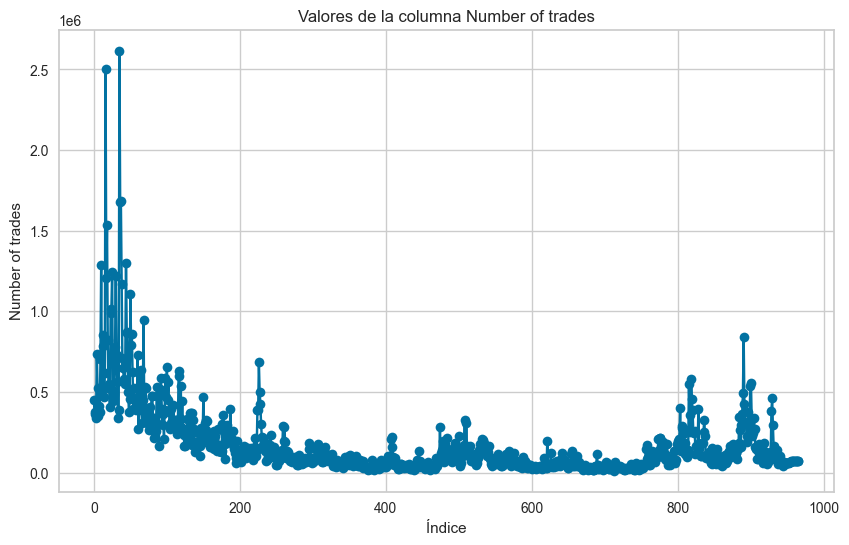

In [152]:
import matplotlib.pyplot as plt

column_name = 'Number of trades'
plt.figure(figsize=(10, 6))
plt.plot(feature_dataset[column_name], marker='o', linestyle='-', color='b')
plt.title(f'Valores de la columna {column_name}')
plt.xlabel('Índice')
plt.ylabel(column_name)
plt.grid(True)
plt.show()

In [ ]:
feature_dataset.tail()

,Open_time,Open,High,Low,Close,Number of trades,Close_BTCUSDT,Volume_BTCUSDT,Number_of_trades_BTCUSDT,Close_ETHUSDT,Volume_ETHUSDT,Number_of_trades_ETHUSDT,Close_BNBUSDT,Volume_BNBUSDT,Number_of_trades_BNBUSDT,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,buy_1000x_high_coinbase,sell_1000x_high_coinbase,total_trades_coinbase,Tweets_Utilizados,Tweets_Utilizados_coin,Tweets_Utilizados_referentes,Tweets_Utilizados_whale_alert,Buy_1000x_high,sell_1000x_high,total_trades_binance
952,2024-05-06,6.95,7.19,6.44,6.79,59881.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.80,6.91,7.34,6.80,6.26,42.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,346.53,309.34,NaN
953,2024-05-07,7.03,7.29,6.49,6.86,59881.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.81,6.90,7.34,6.81,6.28,44.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,350.07,312.35,NaN
954,2024-05-08,7.10,7.35,6.52,6.95,58945.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.82,6.91,7.36,6.82,6.29,46.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,351.54,313.07,NaN
955,2024-05-09,7.17,7.44,6.59,7.01,60541.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.84,6.92,7.37,6.84,6.30,48.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,350.85,314.61,NaN
956,2024-05-10,7.22,7.49,6.63,7.06,67568.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.83,6.93,7.34,6.83,6.31,49.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,351.93,314.11,NaN


In [153]:
validation.tail(10)

,Open_time,Open,High,Low,Close,Number of trades,Close_BTCUSDT,Volume_BTCUSDT,Number_of_trades_BTCUSDT,Close_ETHUSDT,Volume_ETHUSDT,Number_of_trades_ETHUSDT,Close_BNBUSDT,Volume_BNBUSDT,Number_of_trades_BNBUSDT,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,buy_1000x_high_coinbase,sell_1000x_high_coinbase,total_trades_coinbase,Tweets_Utilizados,Tweets_Utilizados_coin,Tweets_Utilizados_referentes,Tweets_Utilizados_whale_alert,Buy_1000x_high,sell_1000x_high,total_trades_binance
946,2024-04-30,6.59,6.67,6.04,6.42,115512.00,60672.00,54947.66,1985671.00,3014.05,561717.49,1292873.00,578.40,766513.45,486465.00,6.93,7.13,7.80,6.93,6.05,34.18,51.00,55.00,48709.00,142,187,1.00,23.00,379.00,377.00,70000.00
947,2024-05-01,6.42,6.94,6.13,6.90,175570.00,58364.97,81166.47,2401089.00,2972.46,624963.78,1365039.00,561.80,669027.32,427425.00,6.85,7.11,7.41,6.85,6.29,43.30,42.00,50.00,83718.00,130,177,0.00,36.00,327.00,340.00,107000.00
948,2024-05-02,6.90,7.41,6.69,7.27,109002.00,59060.61,47583.82,1572898.00,2986.19,365939.72,880167.00,560.50,359794.32,250921.00,6.85,7.12,7.42,6.85,6.29,49.27,87.00,57.00,61208.00,461,374,1.00,25.00,270.00,282.00,71000.00
949,2024-05-03,7.27,7.39,7.00,7.24,109634.00,62882.01,43628.40,1558661.00,3102.61,355825.84,859542.00,587.00,342906.43,257575.00,6.90,7.14,7.44,6.90,6.35,48.86,52.00,40.00,46255.00,573,474,1.00,22.00,386.00,635.00,69000.00
950,2024-05-04,7.24,7.28,7.10,7.12,71120.00,63892.04,24368.69,1113509.00,3117.23,196263.95,575026.00,585.70,197129.25,210303.00,6.91,7.13,7.46,6.91,6.36,46.98,68.00,50.00,34251.00,407,472,0.00,14.00,203.00,232.00,49000.00
951,2024-05-05,7.12,7.40,7.01,7.30,72928.00,64012.00,18526.75,992921.00,3136.41,218760.27,600693.00,592.00,180458.24,180794.00,6.94,7.15,7.51,6.94,6.37,50.00,37.00,52.00,29197.00,417,499,0.00,6.00,320.00,284.00,47000.00
952,2024-05-06,7.30,7.47,7.06,7.12,94264.00,63165.19,34674.92,1392557.00,3062.60,355135.30,873200.00,588.20,278669.00,248490.00,6.96,7.15,7.53,6.96,6.39,47.10,49.00,71.00,40027.00,482,531,0.00,25.00,339.00,249.00,59000.00
953,2024-05-07,7.12,7.30,6.98,6.99,64947.00,62312.08,25598.79,1272898.00,3005.69,298796.68,815246.00,576.50,289488.71,266127.00,6.98,7.13,7.52,6.98,6.44,45.10,21.00,25.00,31028.00,495,494,0.00,28.00,296.00,205.00,42000.00
954,2024-05-08,6.99,7.19,6.89,6.98,75550.00,61193.03,26121.19,1415152.00,2974.21,266934.81,830635.00,588.60,297016.62,249379.00,6.99,7.12,7.52,6.99,6.46,44.94,17.00,24.00,32040.00,426,494,0.00,24.00,230.00,177.00,49000.00
955,2024-05-09,6.98,7.09,6.78,7.05,75016.00,63074.01,30660.81,1381957.00,3036.23,238561.75,686147.00,596.80,464857.60,332988.00,7.01,7.11,7.52,7.01,6.50,46.32,18.00,17.00,29314.00,475,464,0.00,16.00,188.00,257.00,50000.00
